# Predicting Obesity from Various Lifestyle and Demographic Factors  

## Here, we are working with survey data involving the physical characteristics and lifestyle choices of a number of individuals. The goal of this study is to analyse what factors are most connected to obesity and develop a model that can predict an individual's obesity as accurately as possible. It is important to note that due to obesity being defined throught the lens of BMI, Weight and Height will provide the most accurate model. However, we will  attempt to design a model witout these two most influential factors.

# Data Preprocessing and cleaning

In [4]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("ObesityProject").getOrCreate()


In [5]:
# Load Data and ensure schema is correct
obesity = spark.read.csv("C:/Users/skitt/Downloads/ObesityDataSet_raw_and_data_sinthetic.csv", header=True, inferSchema=True)
obesity.show(5)
obesity.printSchema()

+------+----+------+------+------------------------------+----+----+---+---------+-----+----+---+---+---+----------+--------------------+-------------------+
|Gender| Age|Height|Weight|family_history_with_overweight|FAVC|FCVC|NCP|     CAEC|SMOKE|CH2O|SCC|FAF|TUE|      CALC|              MTRANS|         NObeyesdad|
+------+----+------+------+------------------------------+----+----+---+---------+-----+----+---+---+---+----------+--------------------+-------------------+
|Female|21.0|  1.62|  64.0|                           yes|  no| 2.0|3.0|Sometimes|   no| 2.0| no|0.0|1.0|        no|Public_Transporta...|      Normal_Weight|
|Female|21.0|  1.52|  56.0|                           yes|  no| 3.0|3.0|Sometimes|  yes| 3.0|yes|3.0|0.0| Sometimes|Public_Transporta...|      Normal_Weight|
|  Male|23.0|   1.8|  77.0|                           yes|  no| 2.0|3.0|Sometimes|   no| 2.0| no|2.0|1.0|Frequently|Public_Transporta...|      Normal_Weight|
|  Male|27.0|   1.8|  87.0|                         

### To properly implement the machine learning models we desire to use, we will utilize factors, also known as encoded categorical variables, for our Non-Integer variables

In [7]:
from pyspark.sql.functions import sum, col
obesity.select([sum(col(c).isNull().cast("int")).alias(c) for c in obesity.columns]).show()


+------+---+------+------+------------------------------+----+----+---+----+-----+----+---+---+---+----+------+----------+
|Gender|Age|Height|Weight|family_history_with_overweight|FAVC|FCVC|NCP|CAEC|SMOKE|CH2O|SCC|FAF|TUE|CALC|MTRANS|NObeyesdad|
+------+---+------+------+------------------------------+----+----+---+----+-----+----+---+---+---+----+------+----------+
|     0|  0|     0|     0|                             0|   0|   0|  0|   0|    0|   0|  0|  0|  0|   0|     0|         0|
+------+---+------+------+------------------------------+----+----+---+----+-----+----+---+---+---+----+------+----------+



In [8]:
from pyspark.sql.functions import floor, round
from pyspark.sql.types import StringType
from pyspark.ml.feature import StringIndexer
from pyspark.sql import functions as F

# 1. Floor the 'Age' column
obesity = obesity.withColumn("Age", floor(obesity["Age"]))

# 2. Convert categorical columns into PySpark equivalent of factors
categorical_columns = [
    'Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 
    'SMOKE', 'SCC', 'CALC', 'MTRANS'
]

# Apply StringIndexer to categorical columns
for col in categorical_columns:
    indexer = StringIndexer(inputCol=col, outputCol=col + "_indexed")
    obesity = indexer.fit(obesity).transform(obesity)

# 3. Custom order for the 'NObeyesdad' variable
custom_order = ["Insufficient_Weight", "Normal_Weight", "Overweight_Level_I", 
                "Overweight_Level_II", "Obesity_Type_I", 
                "Obesity_Type_II", "Obesity_Type_III"]

# Convert NObeyesdad to an ordered factor using StringIndexer
indexer = StringIndexer(inputCol="NObeyesdad", outputCol="NObeyesdad_indexed").setHandleInvalid("skip")
obesity = indexer.fit(obesity).transform(obesity)

# 4. Renaming NObeyesdad levels
revalue_dict = {
    'Insufficient_Weight': 'Insufficient',
    'Normal_Weight': 'Normal',
    'Overweight_Level_I': 'Overweight1',
    'Overweight_Level_II': 'Overweight2',
    'Obesity_Type_I': 'Obesity1',
    'Obesity_Type_II': 'Obesity2',
    'Obesity_Type_III': 'Obesity3'
}

# Apply revalue
for old_val, new_val in revalue_dict.items():
    obesity = obesity.withColumn(
        "NObeyesdad",
        F.when(F.col("NObeyesdad") == old_val, new_val).otherwise(F.col("NObeyesdad"))
    )


# 5. Round and convert certain scaled variables to factors
scaled_columns = {
    'NCP': (1, 4, ["1 meal", "2 meals", "3 meals", "4 meals"]),
    'CH2O': (1, 3, ["1 liter", "2 liters", "3 liters"]),
    'FCVC': (1, 3, ["1", "2", "3"]),
    'FAF': (0, 3, ["0", "1", "2", "3"]),
    'TUE': (0, 4, ["0", "1", "2", "3", "4"])
}

for col, (min_val, max_val, labels) in scaled_columns.items():
    obesity = obesity.withColumn(col, round(obesity[col]))  # Round the values
    indexer = StringIndexer(inputCol=col, outputCol=col + "_indexed").setHandleInvalid("skip")
    obesity = indexer.fit(obesity).transform(obesity)

# Exploratory Data Analysis

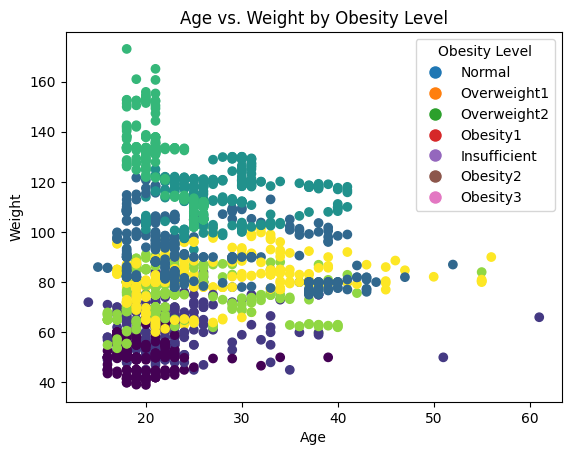

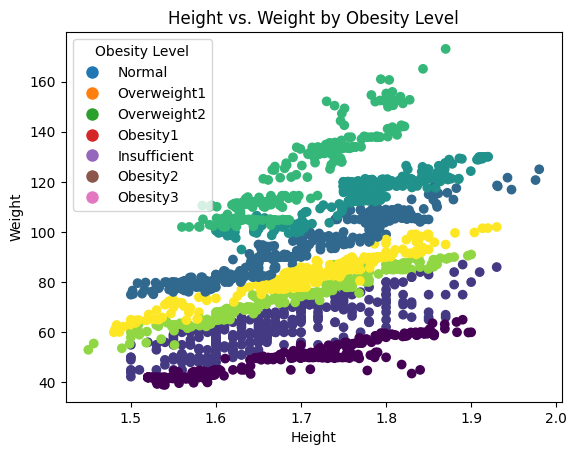

In [10]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert PySpark DataFrame to Pandas for plotting
obesity_pd = obesity.toPandas()

# Scatter plot: Age vs. Weight colored by Obesity Level
plt.scatter(obesity_pd['Age'], obesity_pd['Weight'], c=obesity_pd['NObeyesdad'].astype('category').cat.codes)
plt.xlabel('Age')
plt.ylabel('Weight')
plt.title('Age vs. Weight by Obesity Level')
unique_labels = obesity_pd['NObeyesdad'].unique().tolist()
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='C' + str(i), markersize=10) 
           for i in range(len(unique_labels))]
plt.legend(handles=handles, labels=unique_labels, title='Obesity Level', loc='best')
plt.show()

# Scatter plot: Height vs. Weight colored by Obesity Level
plt.scatter(obesity_pd['Height'], obesity_pd['Weight'], c=obesity_pd['NObeyesdad'].astype('category').cat.codes)
plt.xlabel('Height')
plt.ylabel('Weight')
plt.title('Height vs. Weight by Obesity Level')
unique_labels = obesity_pd['NObeyesdad'].unique().tolist()
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='C' + str(i), markersize=10) 
           for i in range(len(unique_labels))]
plt.legend(handles=handles, labels=unique_labels, title='Obesity Level', loc='best')
plt.show()

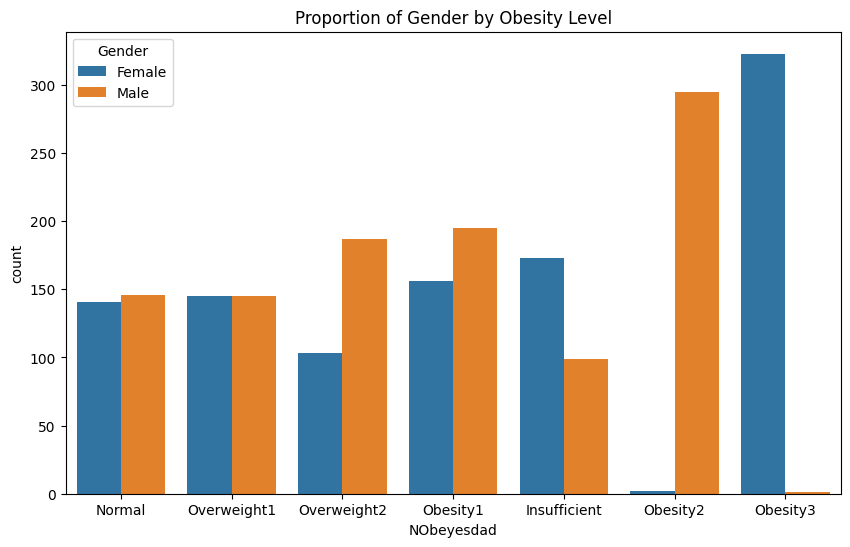

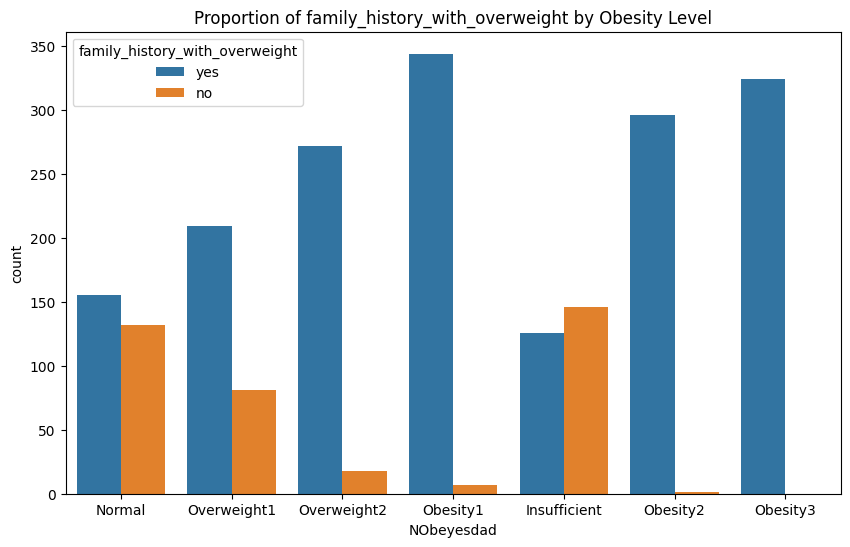

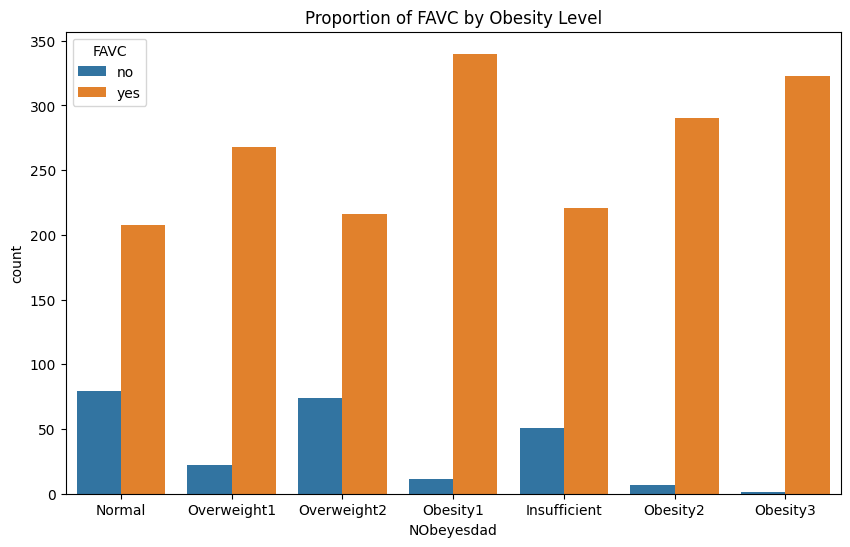

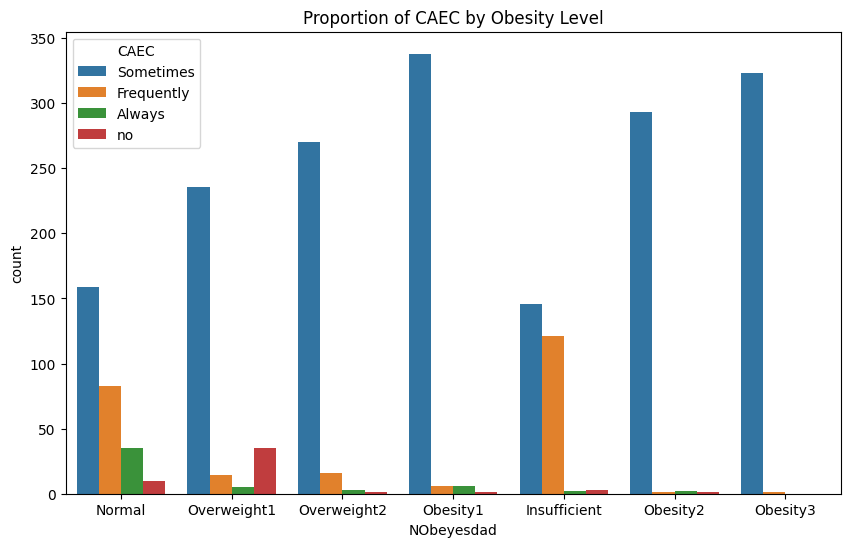

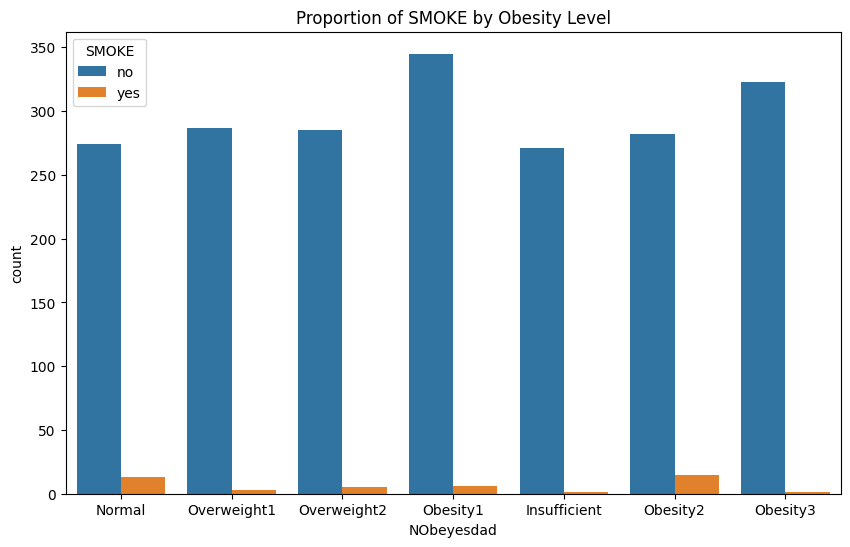

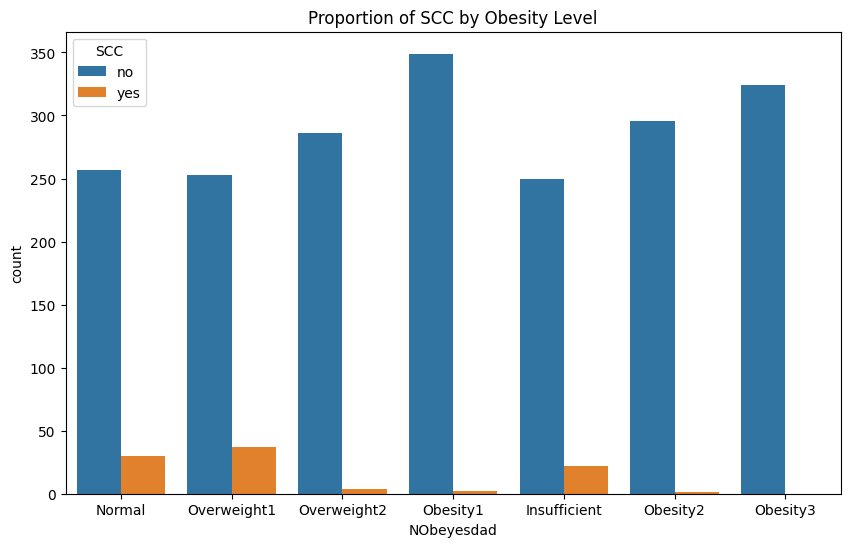

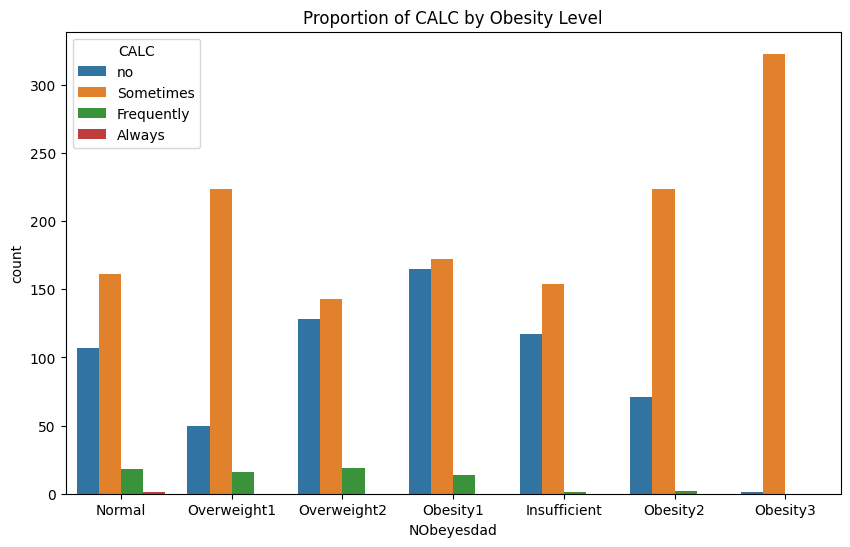

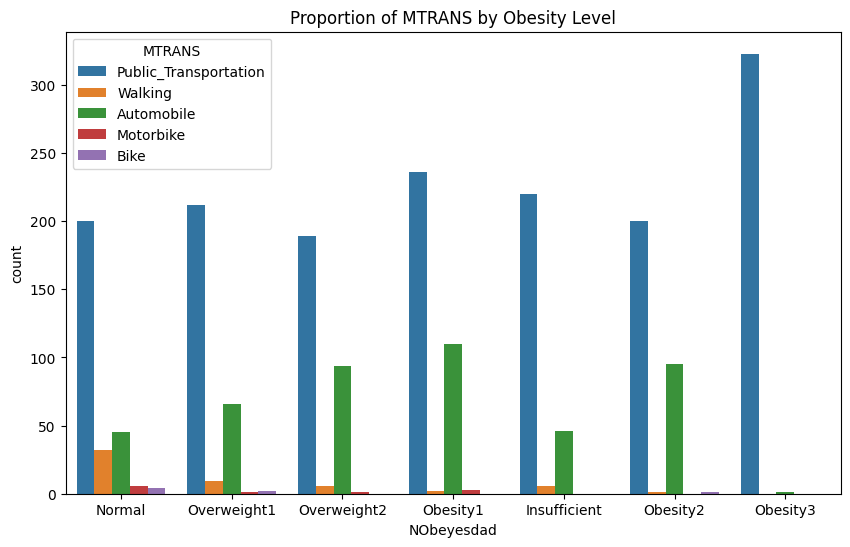

In [11]:
import seaborn as sns

categorical_cols = [col for col in obesity_pd.columns if col != 'NObeyesdad' and obesity_pd[col].dtype == 'object']

for col in categorical_cols:
    plt.figure(figsize=(10, 6))
    sns.countplot(x='NObeyesdad', hue=col, data=obesity_pd)
    plt.title(f"Proportion of {col} by Obesity Level")
    plt.show()


## Variance of proportios is calculated for each factor variable to better understand their predictive power and 
##   perform some preliminary model selection. Our Criteria for removing the variables come if their variance of proportions
##   are greater than or equal to 1/7 = .1429, as the variables to be kept should have a proportion greater than the proportion of one obesity level, hence 1/7.
##   Variables that don't meet this are dropped, allowing us to do some preliminary variable selection as shown in the last two lines of code in this section

In [13]:
from pyspark.sql import Window

# Function to calculate variance of proportions
def varcalc(df, feature):
    proportions = df.groupBy(feature).count().withColumn('proportion', F.col('count') / F.sum('count').over(Window.partitionBy()))
    overall_proportion = proportions.select(F.mean('proportion')).collect()[0][0]
    variance = proportions.withColumn('variance', (F.col('proportion') - overall_proportion) ** 2).agg(F.sum('variance')).collect()[0][0]
    return variance

# List of variables to calculate variance for
vars = obesity.columns[0:15]  
variances = {}

for v in vars:
    if v != "NObeyesdad":
        variances[v] = varcalc(obesity, v)

# Filter variables with variance greater than threshold (1/7 = 0.1429)
selected_vars = {k: v for k, v in variances.items() if v >= 0.1429}
print(selected_vars)

# Removing variables that don't meet criteria
rem = ["Gender", "family_history_with_overweight", "FCVC", "CH2O", "FAF", "TUE", "CALC",
      "Gender_indexed", "family_history_with_overweight_indexed", "FCVC_indexed", "CH2O_indexed", "FAF_indexed", "TUE_indexed", "CALC_indexed"]
obesity = obesity.drop(*rem)

# Show the remaining columns
obesity.printSchema()

{'family_history_with_overweight': 0.20176744449064604, 'FAVC': 0.294821782362626, 'NCP': 0.2692473791721916, 'CAEC': 0.46341337394680493, 'SMOKE': 0.45918247361444564, 'SCC': 0.4131839919072257, 'CALC': 0.2831803970135903}
root
 |-- Age: long (nullable = true)
 |-- Height: double (nullable = true)
 |-- Weight: double (nullable = true)
 |-- FAVC: string (nullable = true)
 |-- NCP: double (nullable = true)
 |-- CAEC: string (nullable = true)
 |-- SMOKE: string (nullable = true)
 |-- SCC: string (nullable = true)
 |-- MTRANS: string (nullable = true)
 |-- NObeyesdad: string (nullable = true)
 |-- FAVC_indexed: double (nullable = false)
 |-- CAEC_indexed: double (nullable = false)
 |-- SMOKE_indexed: double (nullable = false)
 |-- SCC_indexed: double (nullable = false)
 |-- MTRANS_indexed: double (nullable = false)
 |-- NObeyesdad_indexed: double (nullable = false)
 |-- NCP_indexed: double (nullable = false)



# Logistic Regression Model

### When we implement our Logistic Regression Model, we will implement a BMI model defined from Height and Weight as our baseline model and we will seek to develop as accurate of a model without the two factors directly involved in the calculation of the obesity metric

### BMI Based Model

Test Accuracy: 0.9409


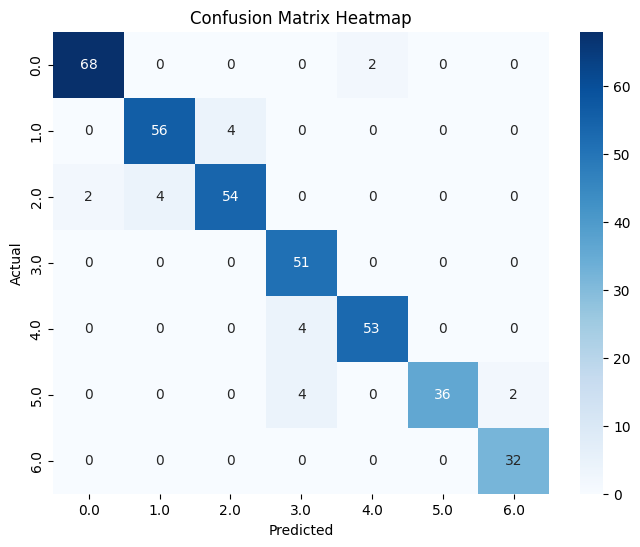

In [17]:
from pyspark.ml.feature import  VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

BMIfeatures = obesity.columns[1:3]
featureColumns = [col for col in obesity.columns if col in BMIfeatures] 
assembler = VectorAssembler(inputCols=featureColumns, outputCol="features")
obesityPrepared = assembler.transform(obesity)
obesityPrepared = obesityPrepared.withColumnRenamed("NObeyesdad_indexed", "labels")

#Split the data into 80% training and 20% testing
train, test = obesityPrepared.randomSplit([0.8, 0.2], seed=42)

lgr = LogisticRegression(featuresCol="features", labelCol="labels", maxIter=10)
lgrModel = lgr.fit(train)

predictions = lgrModel.transform(test)

evaluator = MulticlassClassificationEvaluator(labelCol="labels", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print(f"Test Accuracy: {accuracy:.4f}")

confMatrix = predictions.groupBy("labels", "prediction").count().orderBy("labels", "prediction")

confMatrix_pd = confMatrix.toPandas()
confMatrix_pivot = confMatrix_pd.pivot(index='labels', columns='prediction', values='count').fillna(0)

plt.figure(figsize=(8, 6))
sns.heatmap(confMatrix_pivot, annot=True, fmt="g", cmap="Blues", cbar=True)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()


## Non-BMI Based Feature Model

Test Accuracy: 0.3306


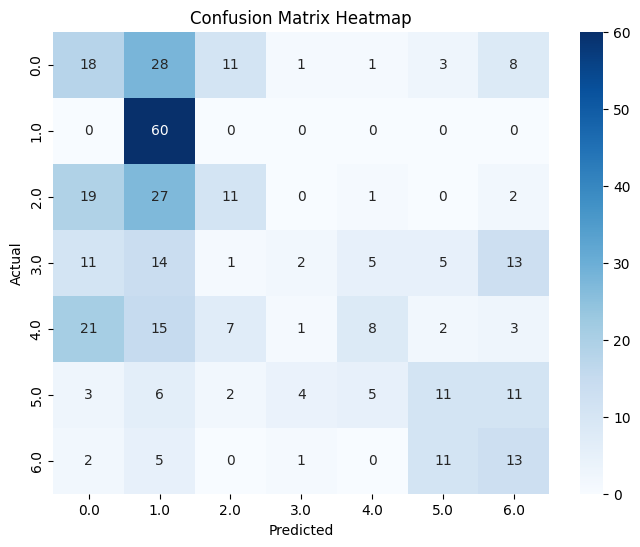

In [19]:
featureColumns = [col for col in obesity.columns if col not in BMIfeatures and col != 'NObeyesdad_indexed']
featureColumns = featureColumns[8:]
featureColumns.append('Age')

assembler = VectorAssembler(inputCols=featureColumns, outputCol="features")
obesityPrepared = assembler.transform(obesity)
obesityPrepared = obesityPrepared.withColumnRenamed("NObeyesdad_indexed", "labels")

#Split the data into 80% training and 20% testing
train, test = obesityPrepared.randomSplit([0.8, 0.2], seed=42)

lgr = LogisticRegression(featuresCol="features", labelCol="labels", maxIter=10)
lgrModel = lgr.fit(train)

predictions = lgrModel.transform(test)

evaluator = MulticlassClassificationEvaluator(labelCol="labels", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print(f"Test Accuracy: {accuracy:.4f}")

confMatrix = predictions.groupBy("labels", "prediction").count().orderBy("labels", "prediction")

confMatrix_pd = confMatrix.toPandas()
confMatrix_pivot = confMatrix_pd.pivot(index='labels', columns='prediction', values='count').fillna(0)

plt.figure(figsize=(8, 6))
sns.heatmap(confMatrix_pivot, annot=True, fmt="g", cmap="Blues", cbar=True)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()

### As we can see, the lifestyle features alone struggle significantly when it comes to predicting and modeling obesity

## Full feature model

Test Accuracy: 0.8495


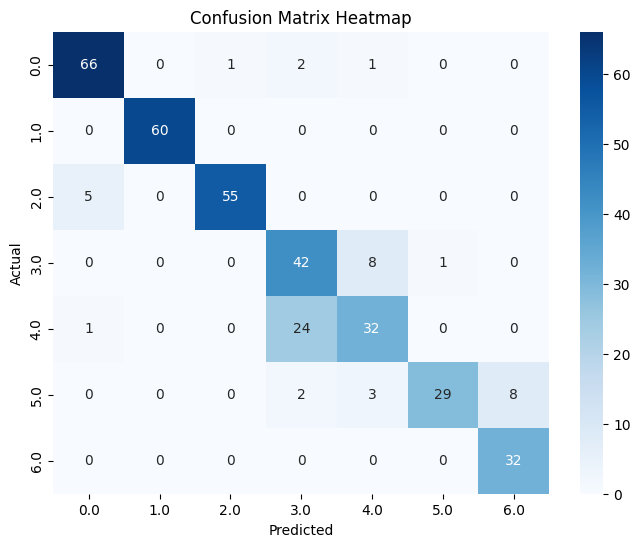

In [22]:
featureColumns = [col for col in obesity.columns if col not in BMIfeatures and col != 'NObeyesdad_indexed']
featureColumns = featureColumns[8:]
featureColumns.append('Age')
featureColumns.append('Height')
featureColumns.append('Weight')

assembler = VectorAssembler(inputCols=featureColumns, outputCol="features")
obesityPrepared = assembler.transform(obesity)
obesityPrepared = obesityPrepared.withColumnRenamed("NObeyesdad_indexed", "labels")

#Split the data into 80% training and 20% testing
train, test = obesityPrepared.randomSplit([0.8, 0.2], seed=42)

lgr = LogisticRegression(featuresCol="features", labelCol="labels", maxIter=10)
lgrModel = lgr.fit(train)

predictions = lgrModel.transform(test)

evaluator = MulticlassClassificationEvaluator(labelCol="labels", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print(f"Test Accuracy: {accuracy:.4f}")

confMatrix = predictions.groupBy("labels", "prediction").count().orderBy("labels", "prediction")

confMatrix_pd = confMatrix.toPandas()
confMatrix_pivot = confMatrix_pd.pivot(index='labels', columns='prediction', values='count').fillna(0)

plt.figure(figsize=(8, 6))
sns.heatmap(confMatrix_pivot, annot=True, fmt="g", cmap="Blues", cbar=True)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()

### When implementing a full model with all the variables, we see our accuracy also decrease, possibly due to there being so much noise that the model's effectiveness dropped even with the height and weight features

# Decision Tree classifier

## BMI based model

Decision Tree at depth = 5
Test Accuracy: 0.8038


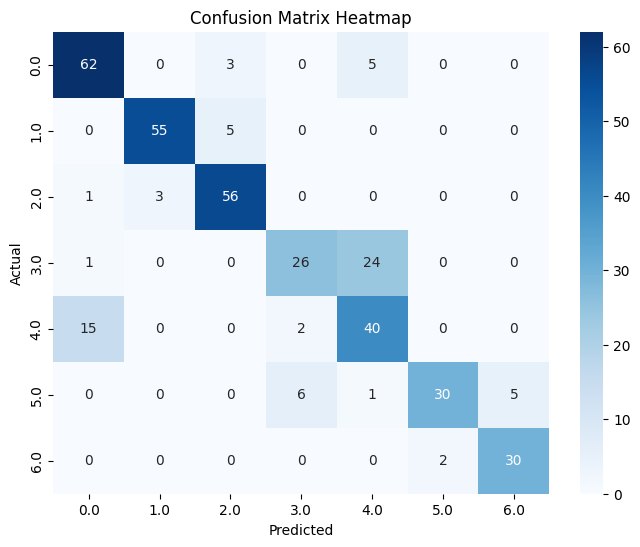

Decision Tree at depth = 10
Test Accuracy: 0.9301


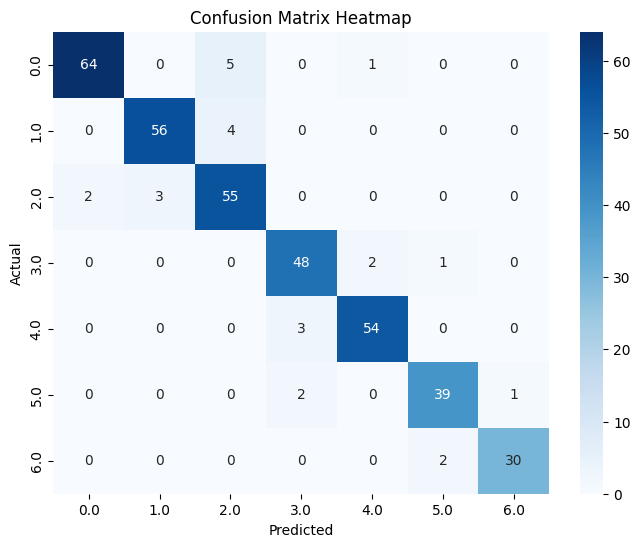

Decision Tree at depth = 15
Test Accuracy: 0.9247


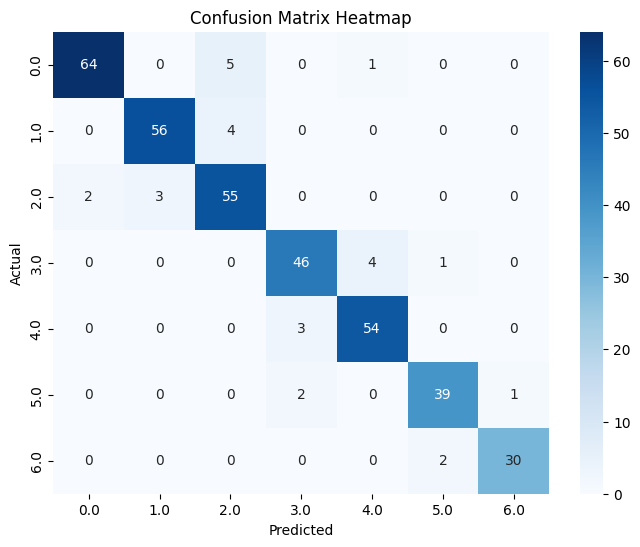

Decision Tree at depth = 20
Test Accuracy: 0.9247


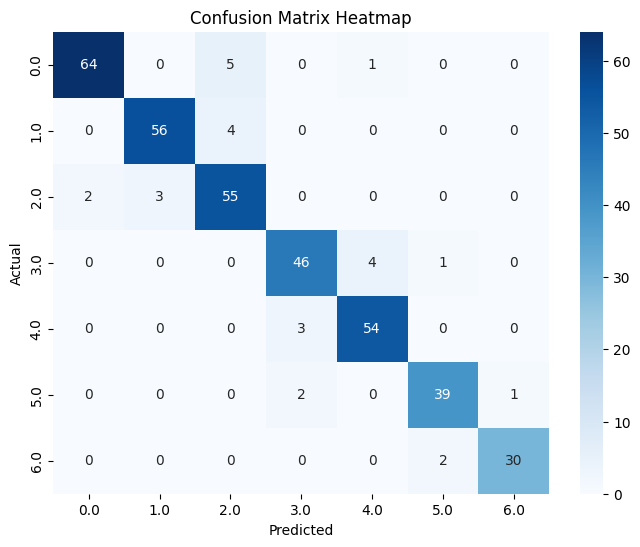

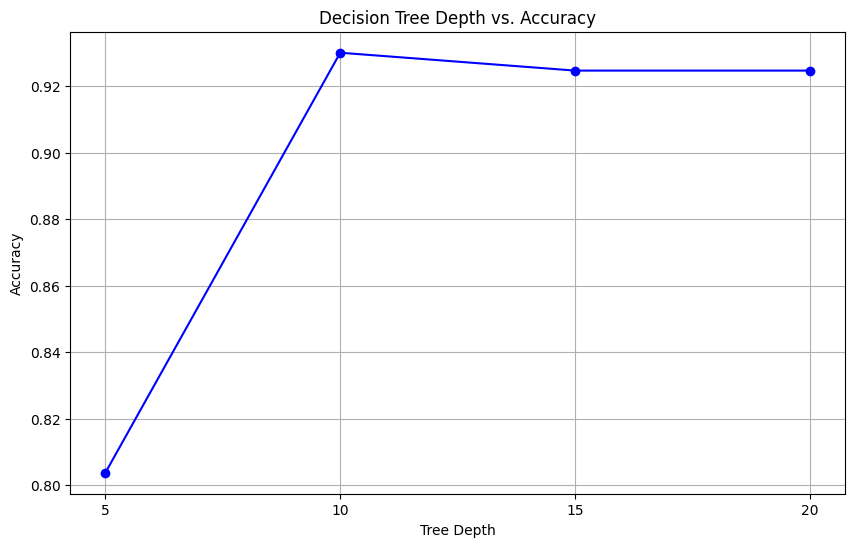

In [39]:
from pyspark.ml.classification import DecisionTreeClassifier


BMIfeatures = obesity.columns[1:3]
featureColumns = [col for col in obesity.columns if col in BMIfeatures] 
assembler = VectorAssembler(inputCols=featureColumns, outputCol="features")
obesityPrepared = assembler.transform(obesity)
obesityPrepared = obesityPrepared.withColumnRenamed("NObeyesdad_indexed", "labels")

#Split the data into 80% training and 20% testing
train, test = obesityPrepared.randomSplit([0.8, 0.2], seed=42)
depths = [5, 10, 15, 20]
acc = []
for i in depths:
    print("Decision Tree at depth =", i)
    dtc = DecisionTreeClassifier(featuresCol="features", labelCol="labels", maxDepth = i)
    dtcModel = dtc.fit(train)
    
    predictions = dtcModel.transform(test)
    
    evaluator = MulticlassClassificationEvaluator(labelCol="labels", predictionCol="prediction", metricName="accuracy")
    accuracy = evaluator.evaluate(predictions)
    acc.append(accuracy)
    
    print(f"Test Accuracy: {accuracy:.4f}")
    
    confMatrix = predictions.groupBy("labels", "prediction").count().orderBy("labels", "prediction")
    
    confMatrix_pd = confMatrix.toPandas()
    confMatrix_pivot = confMatrix_pd.pivot(index='labels', columns='prediction', values='count').fillna(0)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(confMatrix_pivot, annot=True, fmt="g", cmap="Blues", cbar=True)
    
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix Heatmap')
    plt.show()

plt.figure(figsize=(10, 6))
plt.plot(depths, acc, marker='o', linestyle='-', color='b')
plt.title('Decision Tree Depth vs. Accuracy')
plt.xlabel('Tree Depth')
plt.ylabel('Accuracy')
plt.grid(True)
plt.xticks(depths)  # Show all depths as x-axis ticks
plt.show()

### Depth 10 yields the highest accuracy

### Non BMI-based Model

Decision Tree at depth = 5
Test Accuracy: 0.4839


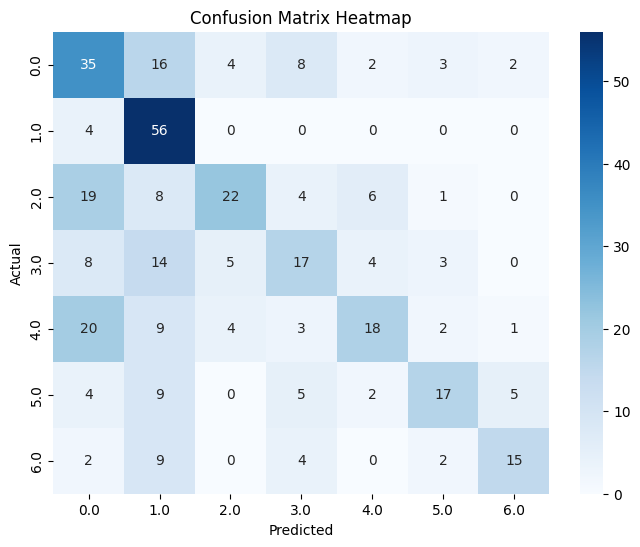

Decision Tree at depth = 10
Test Accuracy: 0.5269


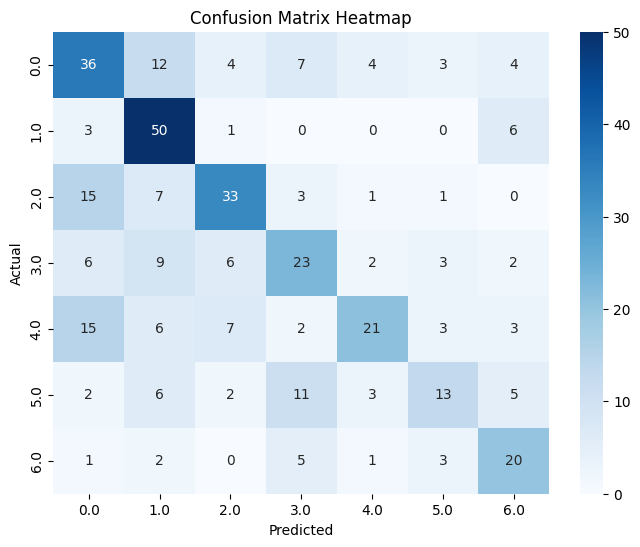

Decision Tree at depth = 15
Test Accuracy: 0.5215


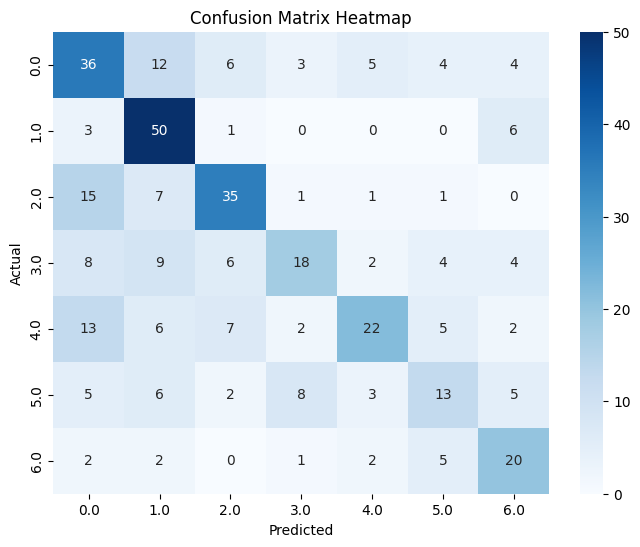

Decision Tree at depth = 20
Test Accuracy: 0.5215


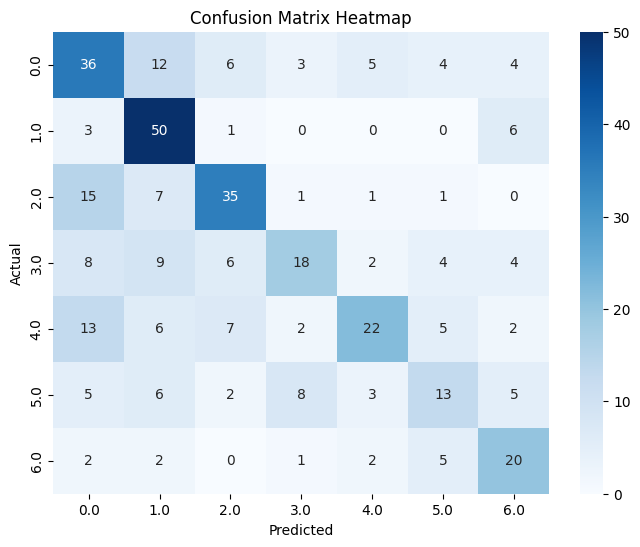

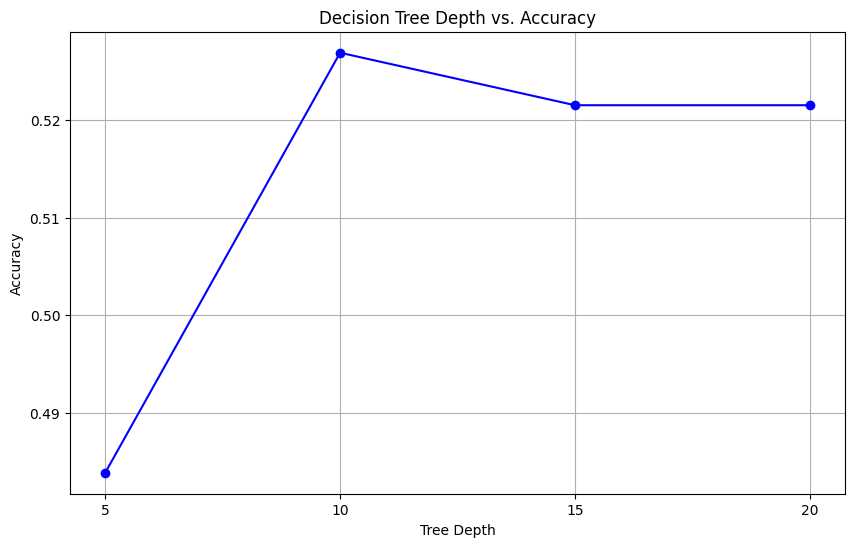

In [42]:
featureColumns = [col for col in obesity.columns if col not in BMIfeatures and col != 'NObeyesdad_indexed']
featureColumns = featureColumns[8:]
featureColumns.append('Age')

assembler = VectorAssembler(inputCols=featureColumns, outputCol="features")
obesityPrepared = assembler.transform(obesity)
obesityPrepared = obesityPrepared.withColumnRenamed("NObeyesdad_indexed", "labels")

#Split the data into 80% training and 20% testing
train, test = obesityPrepared.randomSplit([0.8, 0.2], seed=42)
depths = [5, 10, 15, 20]
acc = []
for i in depths:
    print("Decision Tree at depth =", i)
    dtc = DecisionTreeClassifier(featuresCol="features", labelCol="labels", maxDepth = i)
    dtcModel = dtc.fit(train)
    
    predictions = dtcModel.transform(test)
    
    evaluator = MulticlassClassificationEvaluator(labelCol="labels", predictionCol="prediction", metricName="accuracy")
    accuracy = evaluator.evaluate(predictions)
    acc.append(accuracy)
    
    print(f"Test Accuracy: {accuracy:.4f}")
    
    confMatrix = predictions.groupBy("labels", "prediction").count().orderBy("labels", "prediction")
    
    confMatrix_pd = confMatrix.toPandas()
    confMatrix_pivot = confMatrix_pd.pivot(index='labels', columns='prediction', values='count').fillna(0)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(confMatrix_pivot, annot=True, fmt="g", cmap="Blues", cbar=True)
    
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix Heatmap')
    plt.show()

plt.figure(figsize=(10, 6))
plt.plot(depths, acc, marker='o', linestyle='-', color='b')
plt.title('Decision Tree Depth vs. Accuracy')
plt.xlabel('Tree Depth')
plt.ylabel('Accuracy')
plt.grid(True)
plt.xticks(depths)  # Show all depths as x-axis ticks
plt.show()

### Depth 10 yields the highest accuracy, and we see an improved model under the decision tree in comparison to the logistic regression

## Full Feature Model

Decision Tree at depth = 5
Test Accuracy: 0.8145


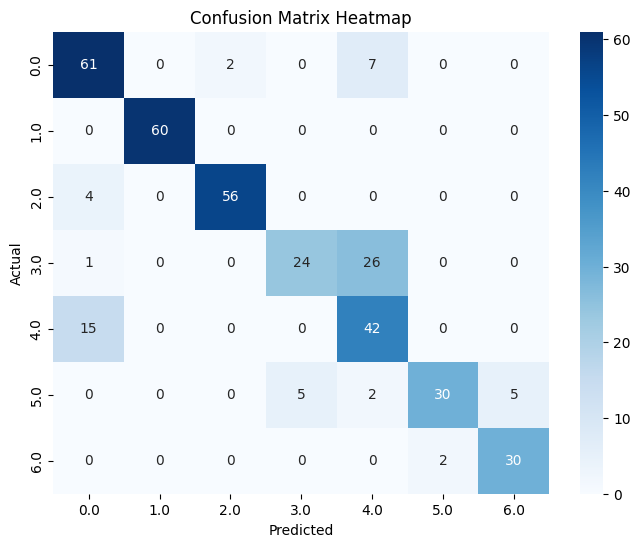

Decision Tree at depth = 10
Test Accuracy: 0.9140


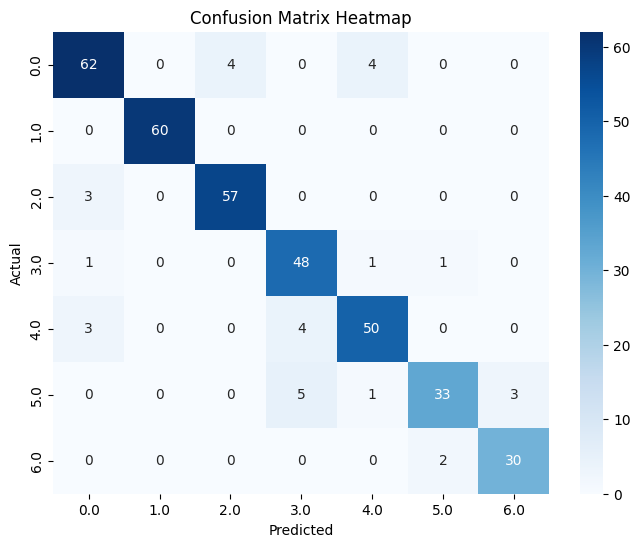

Decision Tree at depth = 15
Test Accuracy: 0.9113


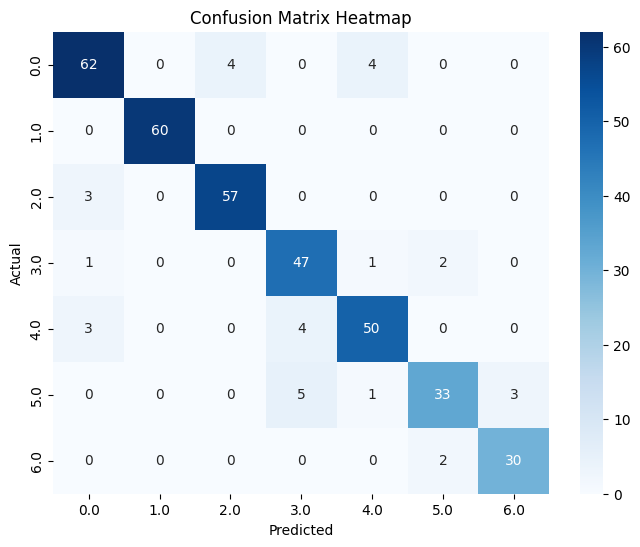

Decision Tree at depth = 20
Test Accuracy: 0.9113


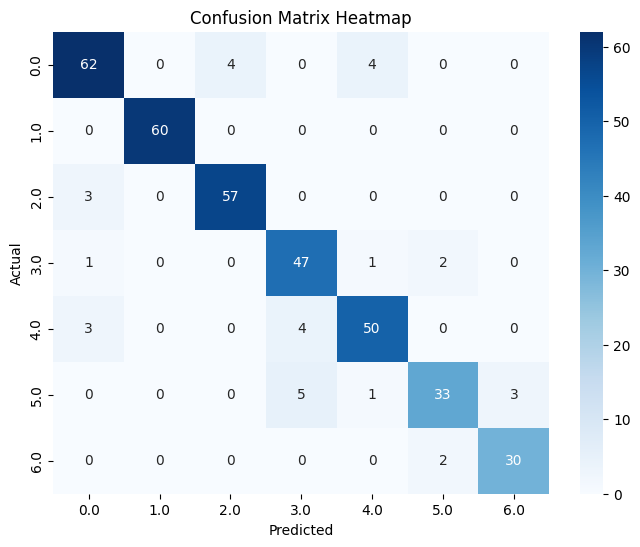

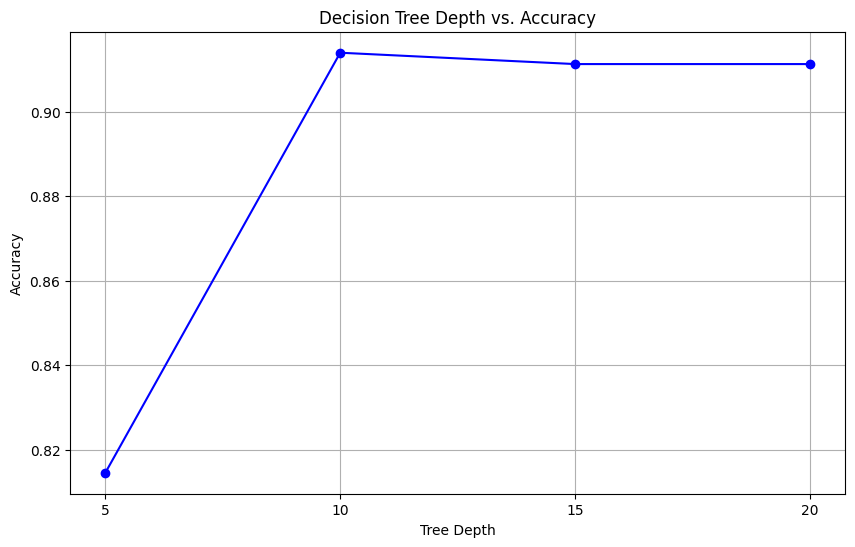

In [47]:
featureColumns = [col for col in obesity.columns if col not in BMIfeatures and col != 'NObeyesdad_indexed']
featureColumns = featureColumns[8:]
featureColumns.append('Age')
featureColumns.append('Height')
featureColumns.append('Weight')

assembler = VectorAssembler(inputCols=featureColumns, outputCol="features")
obesityPrepared = assembler.transform(obesity)
obesityPrepared = obesityPrepared.withColumnRenamed("NObeyesdad_indexed", "labels")

#Split the data into 80% training and 20% testing
train, test = obesityPrepared.randomSplit([0.8, 0.2], seed=42)
depths = [5, 10, 15, 20]
acc = []
for i in depths:
    print("Decision Tree at depth =", i)
    dtc = DecisionTreeClassifier(featuresCol="features", labelCol="labels", maxDepth = i)
    dtcModel = dtc.fit(train)
    
    predictions = dtcModel.transform(test)
    
    evaluator = MulticlassClassificationEvaluator(labelCol="labels", predictionCol="prediction", metricName="accuracy")
    accuracy = evaluator.evaluate(predictions)
    acc.append(accuracy)
    
    print(f"Test Accuracy: {accuracy:.4f}")
    
    confMatrix = predictions.groupBy("labels", "prediction").count().orderBy("labels", "prediction")
    
    confMatrix_pd = confMatrix.toPandas()
    confMatrix_pivot = confMatrix_pd.pivot(index='labels', columns='prediction', values='count').fillna(0)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(confMatrix_pivot, annot=True, fmt="g", cmap="Blues", cbar=True)
    
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix Heatmap')
    plt.show()

plt.figure(figsize=(10, 6))
plt.plot(depths, acc, marker='o', linestyle='-', color='b')
plt.title('Decision Tree Depth vs. Accuracy')
plt.xlabel('Tree Depth')
plt.ylabel('Accuracy')
plt.grid(True)
plt.xticks(depths)  # Show all depths as x-axis ticks
plt.show()

### Depth 10 has the greatest accuracy for the full feature model, and under decision tree classification we see an improved model than the Logistic Regression

# Random Forest Classifier

## BMI based model

Decision Tree at depth = 5
Test Accuracy: 0.7849


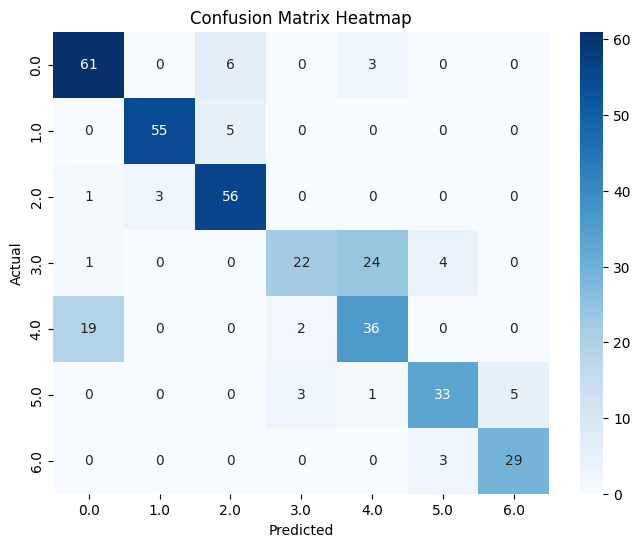

Decision Tree at depth = 10
Test Accuracy: 0.9274


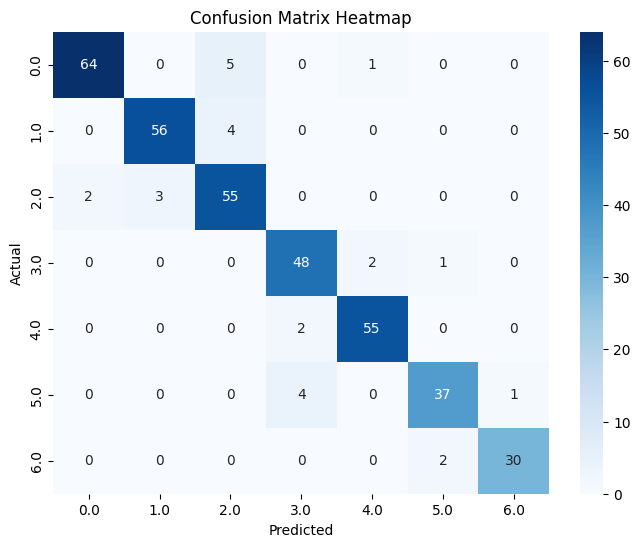

Decision Tree at depth = 15
Test Accuracy: 0.9247


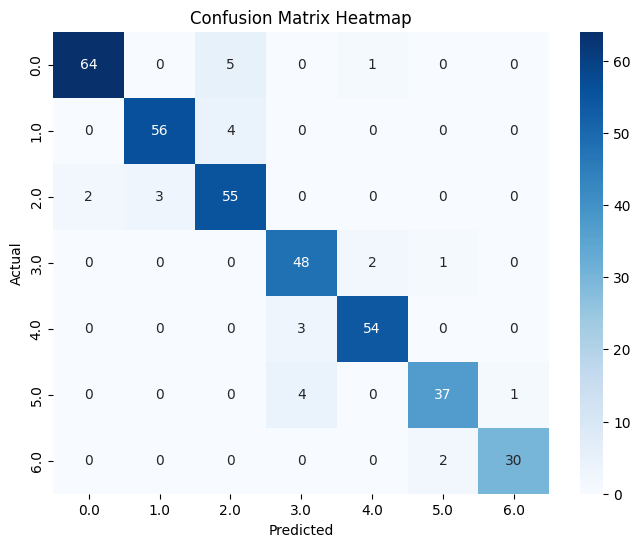

Decision Tree at depth = 20
Test Accuracy: 0.9247


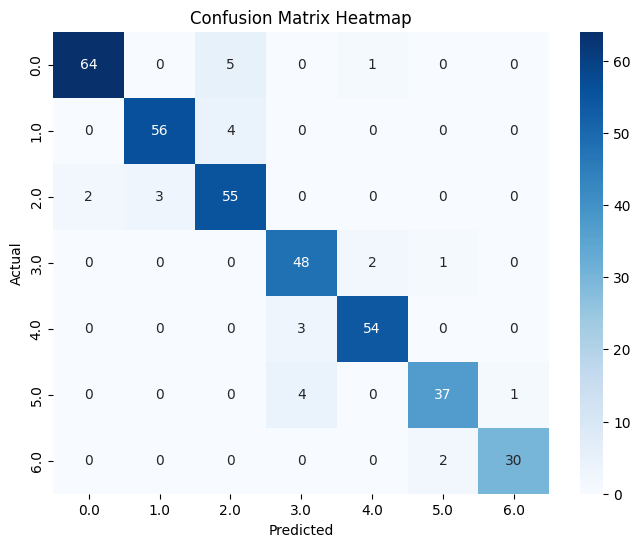

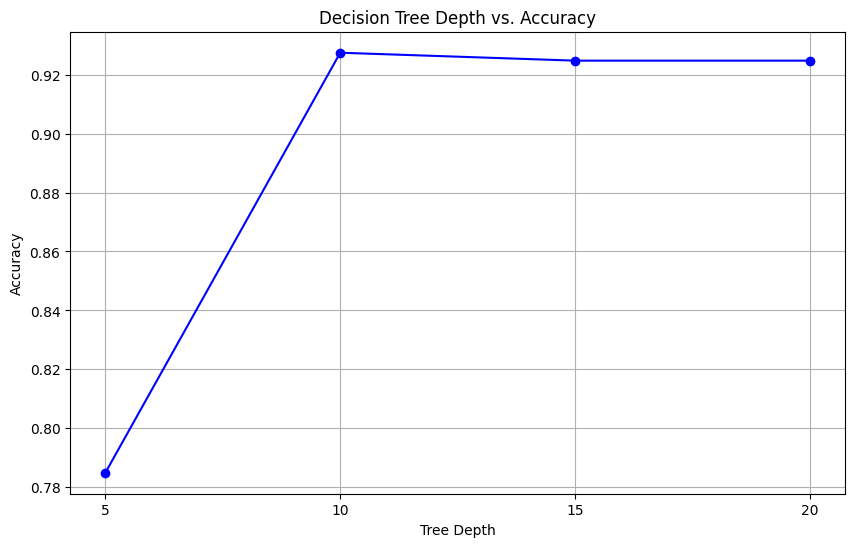

In [64]:
from pyspark.ml.classification import RandomForestClassifier


BMIfeatures = obesity.columns[1:3]
featureColumns = [col for col in obesity.columns if col in BMIfeatures] 

assembler = VectorAssembler(inputCols=featureColumns, outputCol="features")
obesityPrepared = assembler.transform(obesity)
obesityPrepared = obesityPrepared.withColumnRenamed("NObeyesdad_indexed", "labels")

#Split the data into 80% training and 20% testing
train, test = obesityPrepared.randomSplit([0.8, 0.2], seed=42)
depths = [5, 10, 15, 20]
acc = []
for i in depths:
    print("Decision Tree at depth =", i)
    rf = RandomForestClassifier(featuresCol="features", labelCol="labels", numTrees=100, maxDepth=i)
    rfModel = rf.fit(train)
    
    predictions = rfModel.transform(test)
    
    evaluator = MulticlassClassificationEvaluator(labelCol="labels", predictionCol="prediction", metricName="accuracy")
    accuracy = evaluator.evaluate(predictions)
    acc.append(accuracy)
    
    print(f"Test Accuracy: {accuracy:.4f}")
    
    confMatrix = predictions.groupBy("labels", "prediction").count().orderBy("labels", "prediction")
    
    confMatrix_pd = confMatrix.toPandas()
    confMatrix_pivot = confMatrix_pd.pivot(index='labels', columns='prediction', values='count').fillna(0)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(confMatrix_pivot, annot=True, fmt="g", cmap="Blues", cbar=True)
    
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix Heatmap')
    plt.show()

plt.figure(figsize=(10, 6))
plt.plot(depths, acc, marker='o', linestyle='-', color='b')
plt.title('Decision Tree Depth vs. Accuracy')
plt.xlabel('Tree Depth')
plt.ylabel('Accuracy')
plt.grid(True)
plt.xticks(depths)  # Show all depths as x-axis ticks
plt.show()

### Depth 10 yields the highest accuracy

### Non BMI-based Model

Decision Tree at depth = 5
Test Accuracy: 0.5161


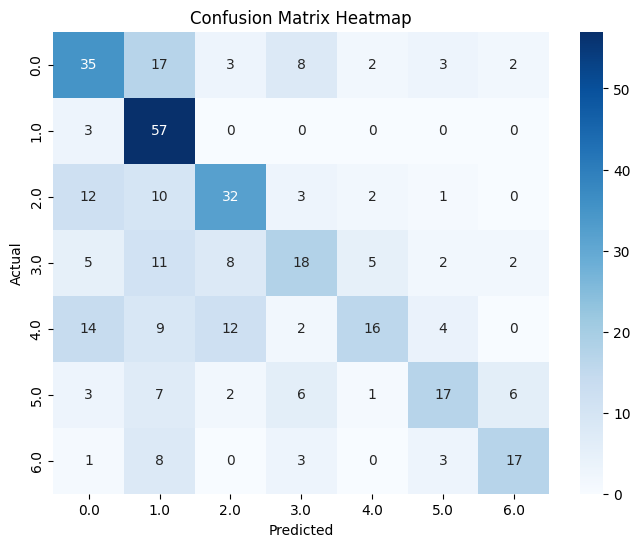

Decision Tree at depth = 10
Test Accuracy: 0.5457


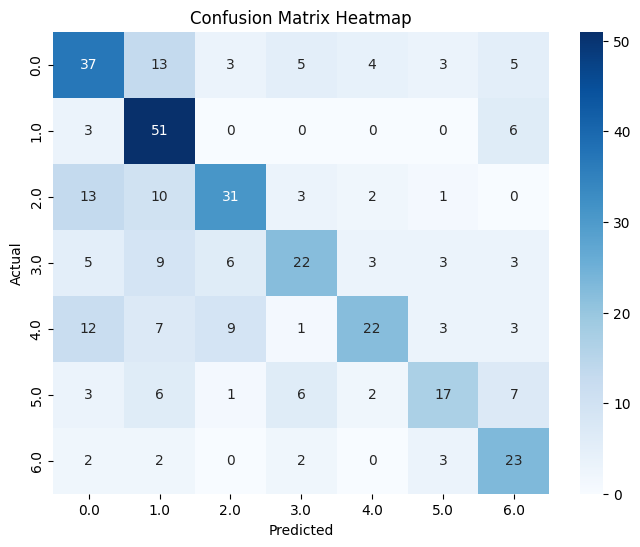

Decision Tree at depth = 15
Test Accuracy: 0.5511


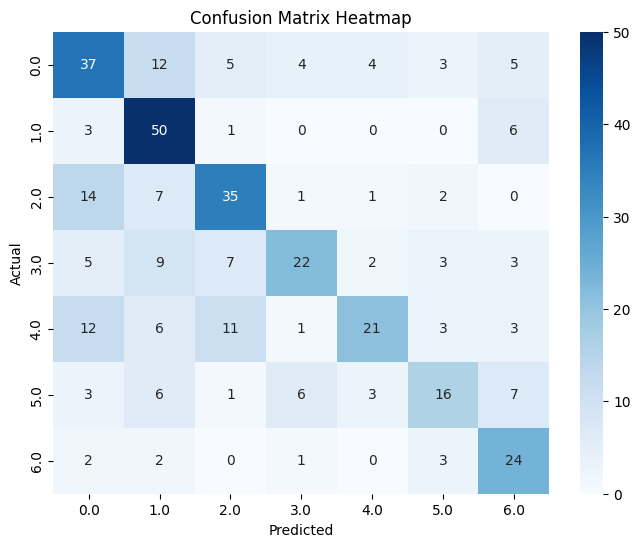

Decision Tree at depth = 20
Test Accuracy: 0.5511


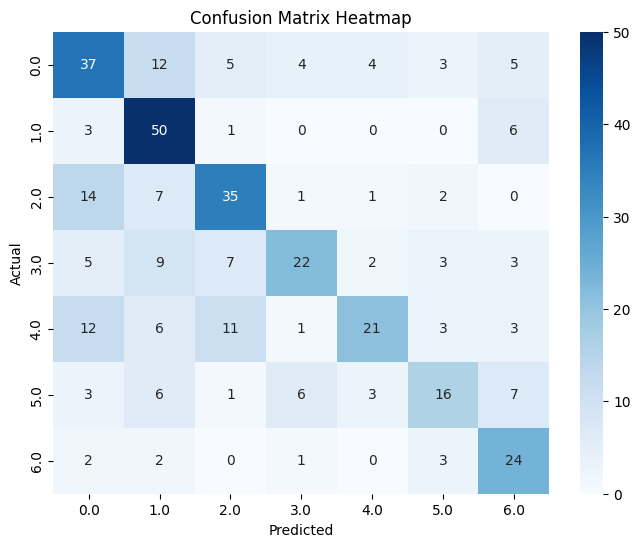

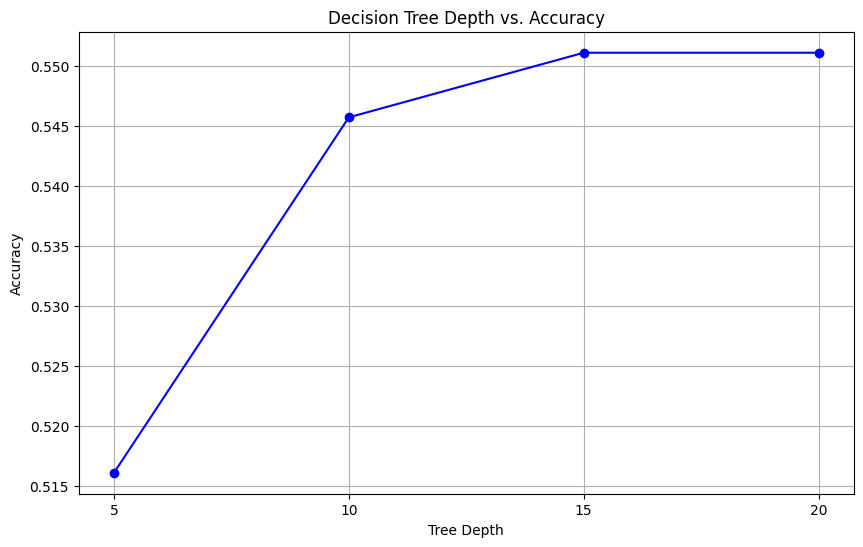

In [66]:
featureColumns = [col for col in obesity.columns if col not in BMIfeatures and col != 'NObeyesdad_indexed']
featureColumns = featureColumns[8:]
featureColumns.append('Age')

assembler = VectorAssembler(inputCols=featureColumns, outputCol="features")
obesityPrepared = assembler.transform(obesity)
obesityPrepared = obesityPrepared.withColumnRenamed("NObeyesdad_indexed", "labels")

#Split the data into 80% training and 20% testing
train, test = obesityPrepared.randomSplit([0.8, 0.2], seed=42)
depths = [5, 10, 15, 20]
acc = []
for i in depths:
    print("Decision Tree at depth =", i)
    rf = RandomForestClassifier(featuresCol="features", labelCol="labels", numTrees=100, maxDepth=i)
    rfModel = rf.fit(train)
    
    predictions = rfModel.transform(test)
    
    evaluator = MulticlassClassificationEvaluator(labelCol="labels", predictionCol="prediction", metricName="accuracy")
    accuracy = evaluator.evaluate(predictions)
    acc.append(accuracy)
    
    print(f"Test Accuracy: {accuracy:.4f}")
    
    confMatrix = predictions.groupBy("labels", "prediction").count().orderBy("labels", "prediction")
    
    confMatrix_pd = confMatrix.toPandas()
    confMatrix_pivot = confMatrix_pd.pivot(index='labels', columns='prediction', values='count').fillna(0)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(confMatrix_pivot, annot=True, fmt="g", cmap="Blues", cbar=True)
    
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix Heatmap')
    plt.show()

plt.figure(figsize=(10, 6))
plt.plot(depths, acc, marker='o', linestyle='-', color='b')
plt.title('Decision Tree Depth vs. Accuracy')
plt.xlabel('Tree Depth')
plt.ylabel('Accuracy')
plt.grid(True)
plt.xticks(depths)  # Show all depths as x-axis ticks
plt.show()

### Depth 15 yields the highest accuracy and plateau's at depth = 20, and we see the best model of the three for the non-BMI based model

## Full Feature Model

Decision Tree at depth = 5
Test Accuracy: 0.8522


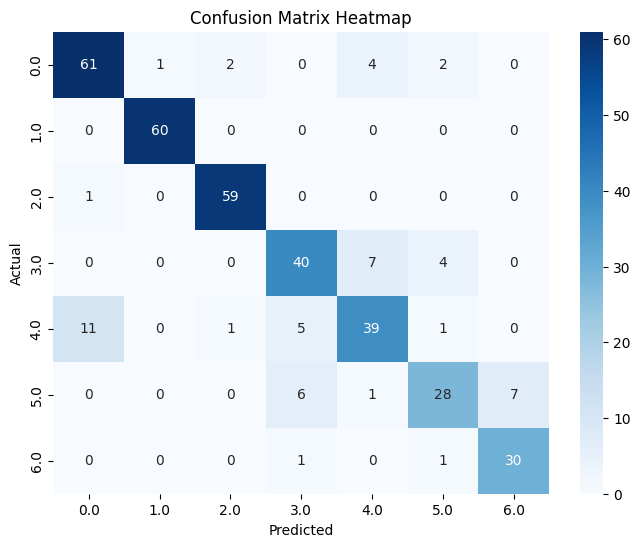

Decision Tree at depth = 10
Test Accuracy: 0.9355


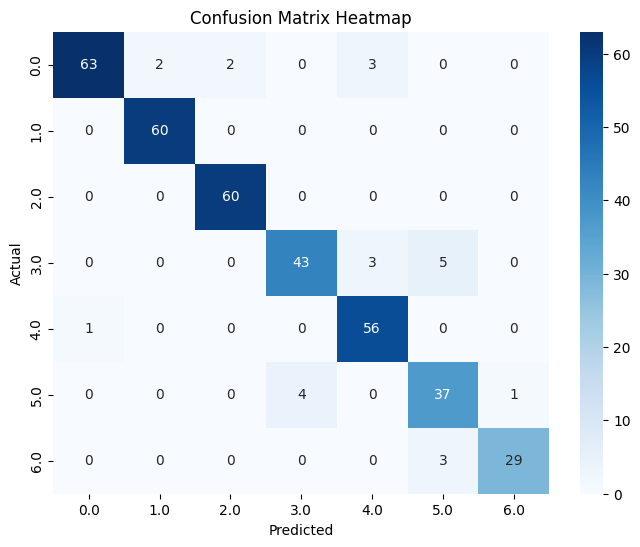

Decision Tree at depth = 15
Test Accuracy: 0.9382


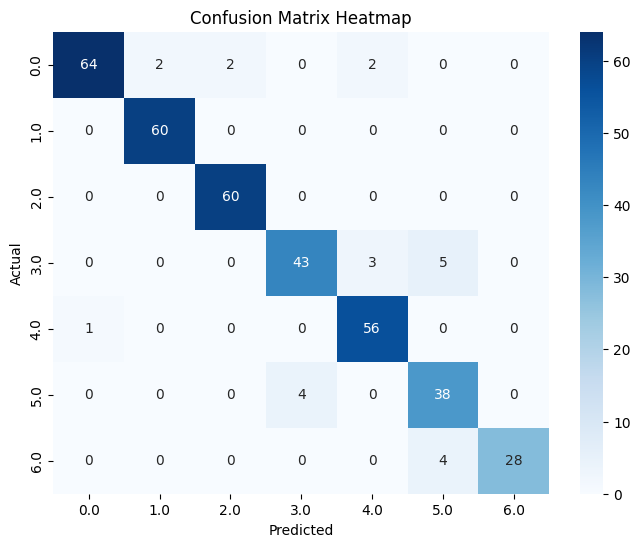

Decision Tree at depth = 20
Test Accuracy: 0.9382


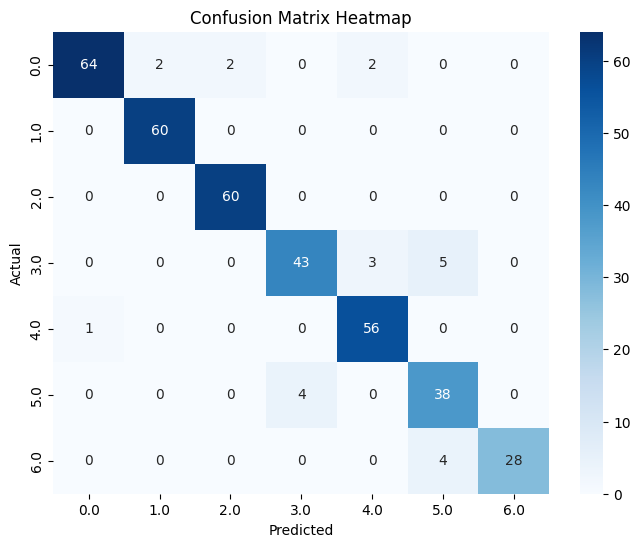

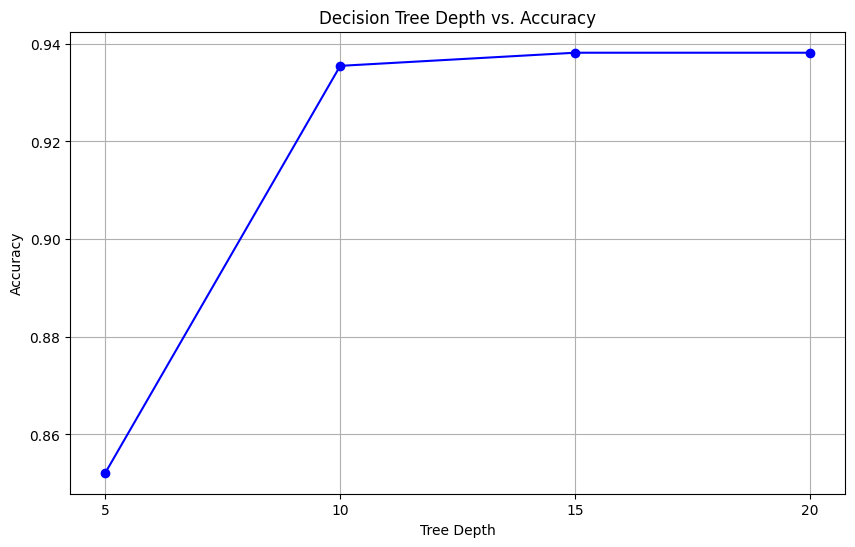

In [69]:
featureColumns = [col for col in obesity.columns if col not in BMIfeatures and col != 'NObeyesdad_indexed']
featureColumns = featureColumns[8:]
featureColumns.append('Age')
featureColumns.append('Height')
featureColumns.append('Weight')

assembler = VectorAssembler(inputCols=featureColumns, outputCol="features")
obesityPrepared = assembler.transform(obesity)
obesityPrepared = obesityPrepared.withColumnRenamed("NObeyesdad_indexed", "labels")

#Split the data into 80% training and 20% testing
train, test = obesityPrepared.randomSplit([0.8, 0.2], seed=42)
depths = [5, 10, 15, 20]
acc = []
for i in depths:
    print("Decision Tree at depth =", i)
    rf = RandomForestClassifier(featuresCol="features", labelCol="labels", numTrees=100, maxDepth=i)
    rfModel = rf.fit(train)
    
    predictions = rfModel.transform(test)
    
    evaluator = MulticlassClassificationEvaluator(labelCol="labels", predictionCol="prediction", metricName="accuracy")
    accuracy = evaluator.evaluate(predictions)
    acc.append(accuracy)
    
    print(f"Test Accuracy: {accuracy:.4f}")
    
    confMatrix = predictions.groupBy("labels", "prediction").count().orderBy("labels", "prediction")
    
    confMatrix_pd = confMatrix.toPandas()
    confMatrix_pivot = confMatrix_pd.pivot(index='labels', columns='prediction', values='count').fillna(0)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(confMatrix_pivot, annot=True, fmt="g", cmap="Blues", cbar=True)
    
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix Heatmap')
    plt.show()

plt.figure(figsize=(10, 6))
plt.plot(depths, acc, marker='o', linestyle='-', color='b')
plt.title('Decision Tree Depth vs. Accuracy')
plt.xlabel('Tree Depth')
plt.ylabel('Accuracy')
plt.grid(True)
plt.xticks(depths)  # Show all depths as x-axis ticks
plt.show()

### Depth 10 yields the highest accuracy, and we see an improved model under the decision tree in comparison to the logistic regression